In [17]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.append('../..')
from augmentation_generator_batch_size import *
from custom_transformers import *

In [18]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [19]:

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


## Random pixels demo
normal labels

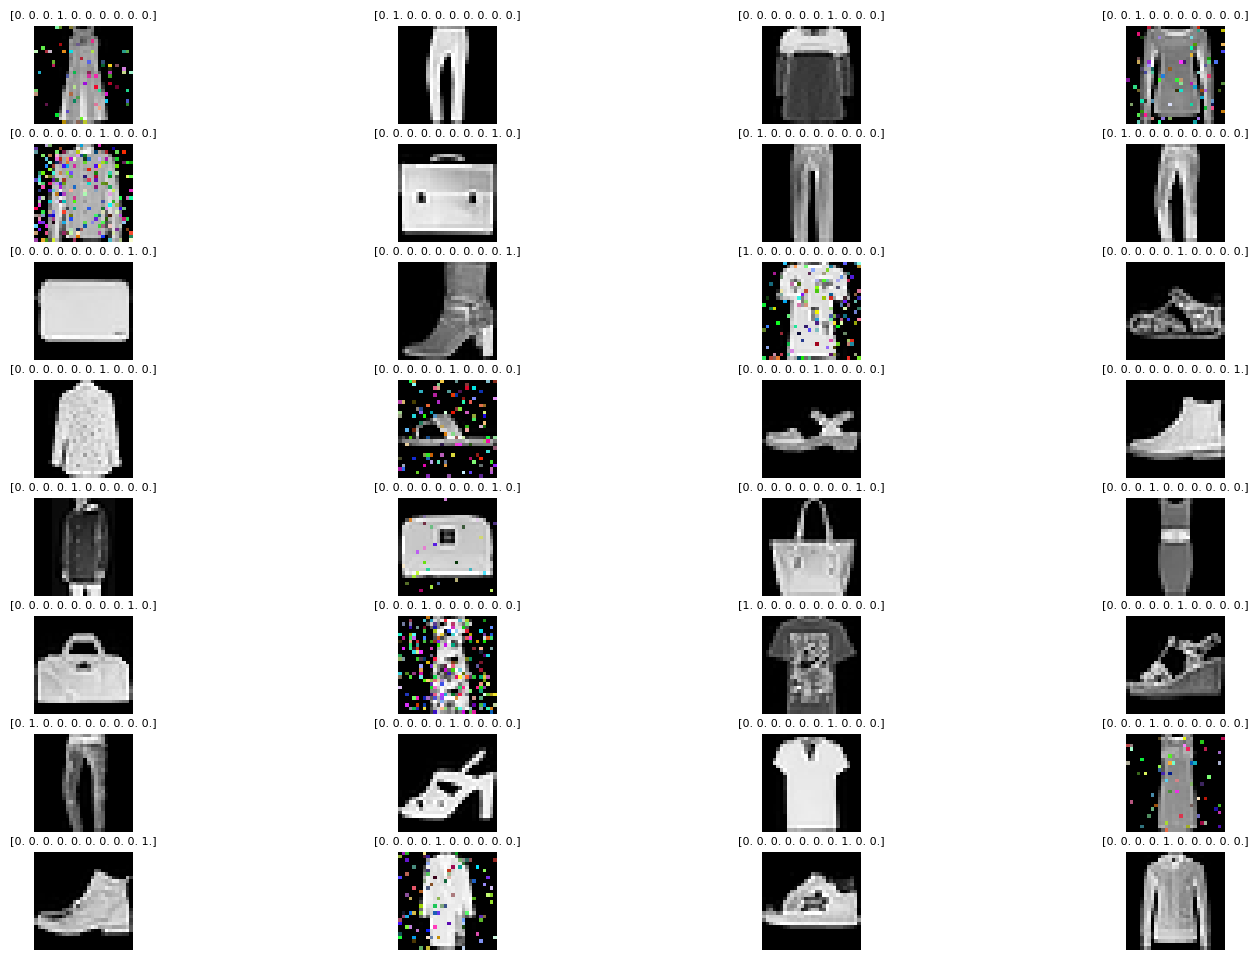

In [4]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= pixel_cutout, augment_fraction=0.5, overwrite=False, soft_label=False)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Random pixels demo
soft labels

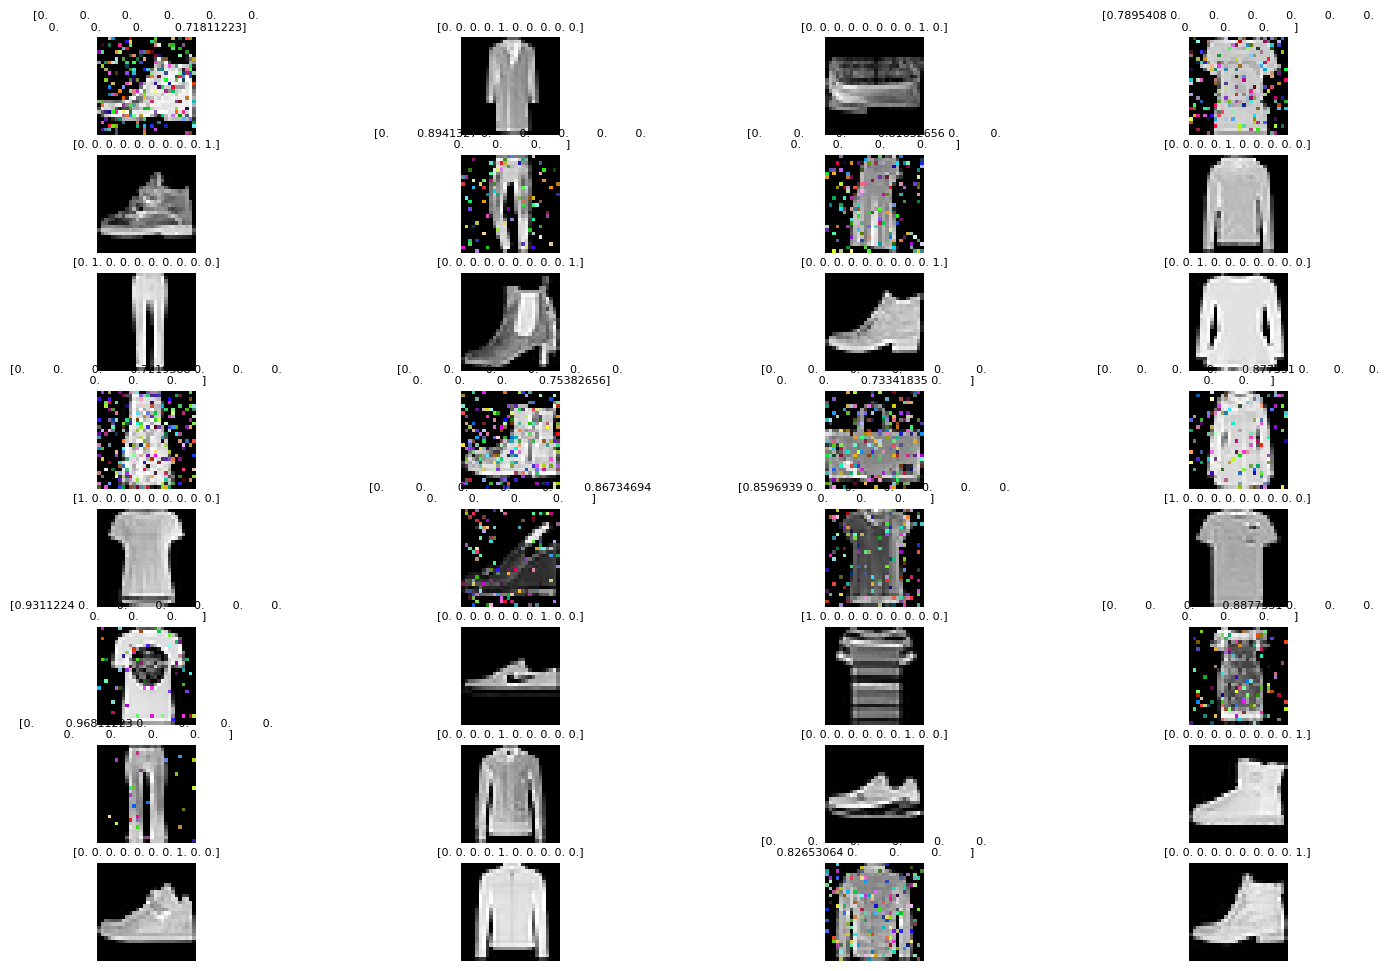

In [35]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= pixel_cutout, augment_fraction=0.5, overwrite=False, soft_label=True)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## CNN max_size = 0.1
normal labels

In [20]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.1, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8152 - loss: 0.5765 - val_accuracy: 0.8902 - val_loss: 0.2940
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9033 - loss: 0.2655 - val_accuracy: 0.9159 - val_loss: 0.2391
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9182 - loss: 0.2229 - val_accuracy: 0.9162 - val_loss: 0.2392
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9277 - loss: 0.1951 - val_accuracy: 0.9206 - val_loss: 0.2240
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9390 - loss: 0.1648 - val_accuracy: 0.9226 - val_loss: 0.2236
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9459 - loss: 0.1447 - val_accuracy: 0.9244 - val_loss: 0.2172


## CNN max size 0.1 statistics:

In [22]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1000
           1       1.00      0.99      0.99      1000
           2       0.88      0.91      0.89      1000
           3       0.92      0.95      0.94      1000
           4       0.90      0.87      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.80      0.77      1000
           7       0.95      0.98      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



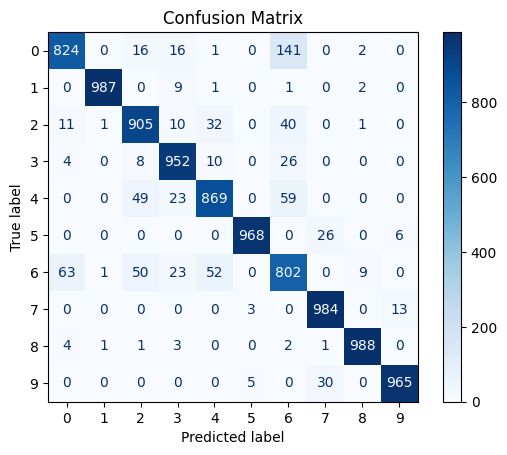

In [23]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9471
Final Validation Accuracy: 0.9244


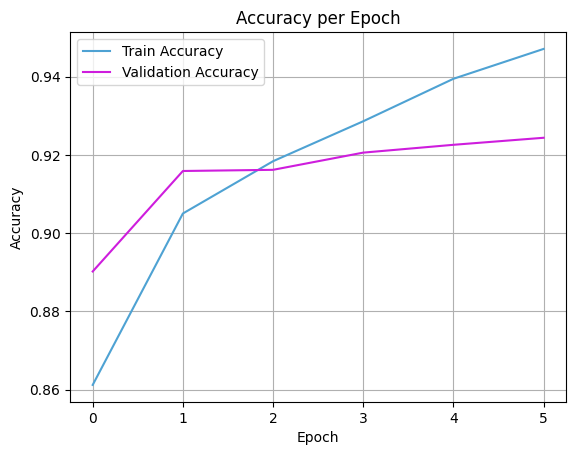

In [24]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

## CNN max size = 0.05
normal labels

In [25]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8114 - loss: 0.5774 - val_accuracy: 0.8834 - val_loss: 0.3077
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9002 - loss: 0.2718 - val_accuracy: 0.9090 - val_loss: 0.2474
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9179 - loss: 0.2224 - val_accuracy: 0.9097 - val_loss: 0.2425
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9292 - loss: 0.1913 - val_accuracy: 0.9149 - val_loss: 0.2394
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9407 - loss: 0.1643 - val_accuracy: 0.9127 - val_loss: 0.2449
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9485 - loss: 0.1387 - val_accuracy: 0.9265 - val_loss: 0.2167


## CNN max size = 0.05 statistics:

In [27]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.88      0.92      0.90      1000
           3       0.94      0.93      0.94      1000
           4       0.89      0.89      0.89      1000
           5       0.99      0.97      0.98      1000
           6       0.83      0.72      0.77      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



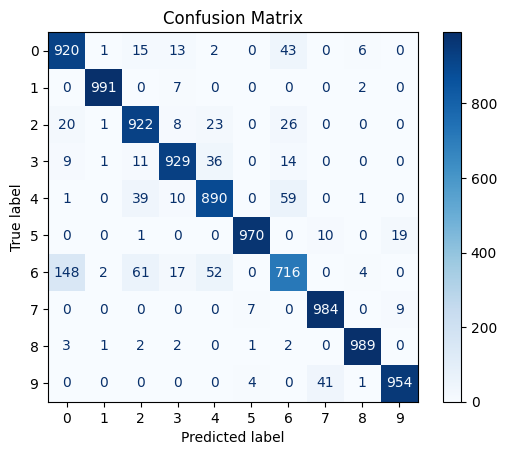

In [28]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9481
Final Validation Accuracy: 0.9265


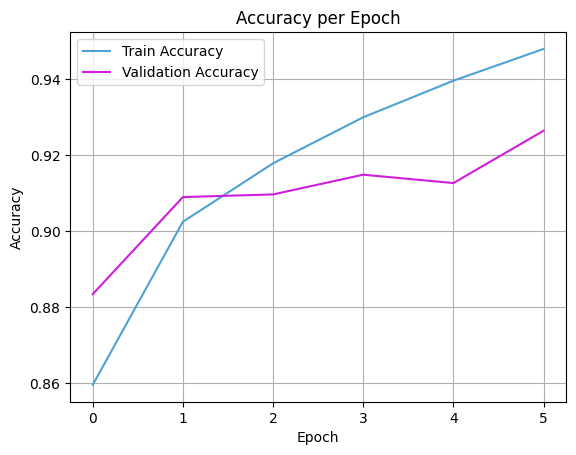

In [29]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

## CNN max size =0.05
with soft labels

In [30]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8108 - loss: 0.5970 - val_accuracy: 0.7722 - val_loss: 0.7230
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7918 - loss: 7.2956 - val_accuracy: 0.6942 - val_loss: 1.7023
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6849 - loss: 215.4286 - val_accuracy: 0.7413 - val_loss: 68.3052
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6576 - loss: 1034.8488 - val_accuracy: 0.7586 - val_loss: 45.9106
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6712 - loss: 2760.0867 - val_accuracy: 0.7052 - val_loss: 278.2783
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6789 - loss: 5613.6050 - val_accuracy: 0.7149 - val_loss: 1108.9722


## CNN max size =0.05 soft labels statistics:

In [32]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1000
           1       1.00      0.94      0.97      1000
           2       0.98      0.05      0.10      1000
           3       0.95      0.64      0.76      1000
           4       0.31      1.00      0.47      1000
           5       0.80      1.00      0.89      1000
           6       0.54      0.20      0.30      1000
           7       0.98      0.85      0.91      1000
           8       0.98      0.94      0.96      1000
           9       0.98      0.87      0.92      1000

    accuracy                           0.71     10000
   macro avg       0.84      0.71      0.70     10000
weighted avg       0.84      0.71      0.70     10000



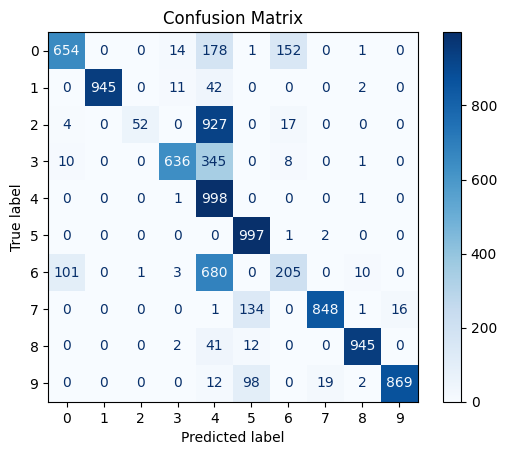

In [33]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.6800
Final Validation Accuracy: 0.7149


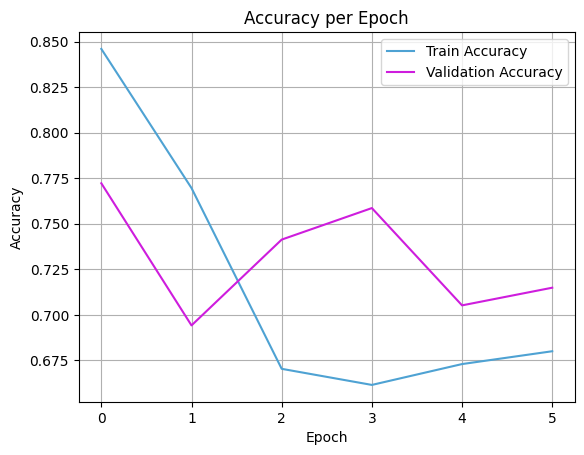

In [34]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()